In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load and contruct the data
df = pd.read_csv("card_transdata.csv")

#drop empty rows
df=df.dropna()

In [3]:
#total number of fraudulent transactions
df[df['fraud'] == 1].count()[-1]

87403

In [4]:
#total number of non-fraudulent transactions
df[df['fraud'] == 0].count()[-1]

912597

In [5]:
#randomly extract 5000 rows from fraudulent and non-fraudulent transactions
pred_fraudulent_transactions = df[df['fraud'] == 1].sample(n=5000)
pred_nonfraudulent_transactions= df[df['fraud'] == 0].sample(n=5000)

#concat to create dataframe for prediction models
pred_df = pd.concat([pred_fraudulent_transactions,pred_nonfraudulent_transactions])

In [6]:
#same for optimizatoin model
opt_fraudulent_transactions = df[df['fraud'] == 1].sample(n=13)
opt_nonfraudulent_transactions= df[df['fraud'] == 0].sample(n=13)
opt_df = pd.concat([opt_fraudulent_transactions,opt_nonfraudulent_transactions])

## Data Processing

In [7]:
#visialize and log transform three continuous variables
x = pred_df["distance_from_home"]
x2 = pred_df["distance_from_last_transaction"]
x3 = pred_df["ratio_to_median_purchase_price"]

opt_x = opt_df["distance_from_home"]
opt_x2 = opt_df["distance_from_last_transaction"]
opt_x3 = opt_df["ratio_to_median_purchase_price"]

Text(0.5, 1.0, 'Log-Transformed Data')

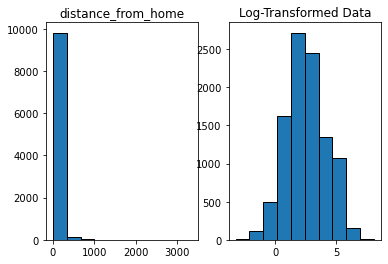

In [8]:
#create log data
logx = np.log(x)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(x, edgecolor='black')
axs[1].hist(logx, edgecolor='black')

#add title to each histogram
axs[0].set_title('distance_from_home')
axs[1].set_title('Log-Transformed Data')

Text(0.5, 1.0, 'Log-Transformed Data')

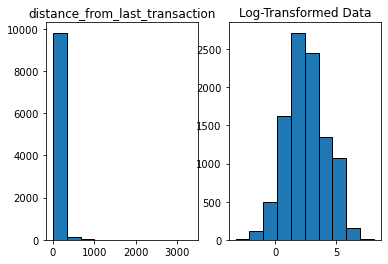

In [9]:
logx2 = np.log(x2)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(x, edgecolor='black')
axs[1].hist(logx, edgecolor='black')

#add title to each histogram
axs[0].set_title('distance_from_last_transaction')
axs[1].set_title('Log-Transformed Data')

Text(0.5, 1.0, 'Log-Transformed Data')

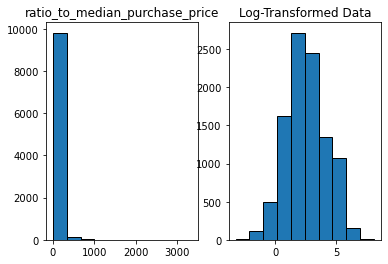

In [10]:
#create log data
logx3 = np.log(x3)

#define grid of plots
fig, axs = plt.subplots(nrows=1, ncols=2)

#create histograms
axs[0].hist(x, edgecolor='black')
axs[1].hist(logx, edgecolor='black')

#add title to each histogram
axs[0].set_title('ratio_to_median_purchase_price')
axs[1].set_title('Log-Transformed Data')

In [11]:
#set up X and y for prediction models
X = pd.concat([logx, logx2, logx3, pred_df.iloc[:,4:7]], axis=1)
y = pred_df["fraud"]

## Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
# Split the data
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.33, random_state = 5)
# Run the model
lr = LogisticRegression(max_iter=10000)
m1 = lr.fit(X_train1, y_train1)

y_test_pred1 = m1.predict(X_test1)

In [13]:
# Calculate the accuracy score and confusion matrix
from sklearn import metrics
print('logistic accuracy: ', metrics.accuracy_score(y_test1, y_test_pred1),'\n')

print(pd.DataFrame(metrics.confusion_matrix(y_test1, y_test_pred1, 
                                                labels = [0,1]), 
                       index = ['true: 0', 'true: 1'], 
                       columns = ['pred:0', 'pred: 1']))

print('\nf1 score: ', metrics.f1_score(y_test1, y_test_pred1))

print('precision : ', metrics.precision_score(y_test1, y_test_pred1))

print('recall : ', metrics.recall_score(y_test1, y_test_pred1))

logistic accuracy:  0.8569696969696969 

         pred:0  pred: 1
true: 0    1384      261
true: 1     211     1444

f1 score:  0.8595238095238096
precision :  0.8469208211143695
recall :  0.8725075528700906


In [14]:
#probabilities from logistic regression
proba=m1.predict_proba(X_test1)[:,1]

In [15]:
#coefficient and intercept
m1.coef_=np.array(m1.coef_)
m1.coef_=m1.coef_.reshape([6, 1])
print(m1.coef_, m1.intercept_)

[[ 0.56992136]
 [ 0.24883669]
 [ 1.7729776 ]
 [-1.18305514]
 [-4.47438702]
 [ 2.75165806]] [-4.45953593]


In [16]:
#obtain linear equation through multiplication
lin=X_test1.dot(m1.coef_)+m1.intercept_
lin[0]

315804   -5.862350
308462    3.389407
117186    1.735038
523110    1.925480
236651    5.085416
            ...   
932414   -4.528152
694585   -4.679390
865581   -0.329308
434944   -6.242787
518461    2.292367
Name: 0, Length: 3300, dtype: float64

In [17]:
len(list(1 / (1 +np.exp(-lin[0]))))

3300

In [18]:
len(proba)

3300

In [19]:
#calculate probabilities
1 / (1 +np.exp(-lin[0]))
d = {'cal_prob':list(1 / (1 +np.exp(-lin[0]))), 'logistic_prob':proba,'y_test_pred': list(y_test_pred1),'y_true':list(y_test1)}
d= pd.DataFrame(d)

## K-Nearest Neighbor

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

#standardize X for KNN
standardizer = StandardScaler()
X_std = standardizer.fit_transform(X)

#split the dataset into train and test
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_std, y, test_size = 0.33, random_state = 5)

In [22]:
#use looping to find the optimal k
from sklearn import metrics
a=[0,0]
f=[0,0]
for i in range (1,11):
    knn4 = KNeighborsClassifier(n_neighbors=i) 
    m2 = knn4.fit(X_train2,y_train2) 
    y_test_pred2 = m2.predict(X_test2) 
    print(i, metrics.accuracy_score(y_test2, y_test_pred2)) #2,3,4,5,6,8,10
    if metrics.accuracy_score(y_test2, y_test_pred2) > a[1]:
        a[0]=i
        a[1] = metrics.accuracy_score(y_test2, y_test_pred2)
    print(i, metrics.f1_score(y_test2, y_test_pred2))
    if metrics.f1_score(y_test2, y_test_pred2) > f[1]:
        f[0]=i
        f[1]=metrics.f1_score(y_test2, y_test_pred2)

1 0.9769696969696969
1 0.9772182254196642
2 0.9724242424242424
2 0.9723320158102767
3 0.9763636363636363
3 0.9768270944741533
4 0.9775757575757575
4 0.9778575703171754
5 0.9724242424242424
5 0.9730689553122225
6 0.9724242424242424
6 0.9729247247842903
7 0.9684848484848485
7 0.9692852923803899
8 0.97
8 0.9706318599822011
9 0.9687878787878788
9 0.969589607322114
10 0.9687878787878788
10 0.9694452684663305


In [23]:
print('KNN accuracy: ', a,'\n')

print(pd.DataFrame(metrics.confusion_matrix(y_test2, y_test_pred2, 
                                                labels = [0,1]), 
                       index = ['true: 0', 'true: 1'], 
                       columns = ['pred:0', 'pred: 1']))

print('\nf1 score: ', f)

print('precision : ', metrics.precision_score(y_test2, y_test_pred2))

print('recall : ', metrics.recall_score(y_test2, y_test_pred2))

KNN accuracy:  [4, 0.9775757575757575] 

         pred:0  pred: 1
true: 0    1563       82
true: 1      21     1634

f1 score:  [4, 0.9778575703171754]
precision :  0.9522144522144522
recall :  0.9873111782477342


## Gradient Boosting Tree

In [24]:
from sklearn.model_selection import train_test_split
X_train3,X_test3,y_train3,y_test3 = train_test_split(X,y,test_size=0.33,random_state=5)

from sklearn.ensemble import GradientBoostingClassifier
gbt = GradientBoostingClassifier()

m3 = gbt.fit(X_train3, y_train3) 
y_test_pred3 = m3.predict(X_test3)

In [25]:

print('GBT accuracy: ', metrics.accuracy_score(y_test3, y_test_pred3),'\n')

print(pd.DataFrame(metrics.confusion_matrix(y_test3, y_test_pred3, 
                                                labels = [0,1]), 
                       index = ['true: 0', 'true: 1'], 
                       columns = ['pred:0', 'pred: 1']))

print('\nf1 score: ', metrics.f1_score(y_test3, y_test_pred3))

print('precision : ', metrics.precision_score(y_test3, y_test_pred3))

print('recall : ', metrics.recall_score(y_test3, y_test_pred3))

GBT accuracy:  0.9963636363636363 

         pred:0  pred: 1
true: 0    1637        8
true: 1       4     1651

f1 score:  0.996378998189499
precision :  0.995177817962628
recall :  0.997583081570997


## Optimization

In [26]:
#log transformation for optimization data as well
opt_x = opt_df["distance_from_home"]
opt_x2 = opt_df["distance_from_last_transaction"]
opt_x3 = opt_df["ratio_to_median_purchase_price"]

opt_logx = np.log(opt_x)
opt_logx2 = np.log(opt_x2)
opt_logx3 = np.log(opt_x3)

opt_X = pd.concat([opt_logx, opt_logx2, opt_logx3, opt_df.iloc[:,4:7]], axis=1)
opt_y = opt_df["fraud"]

In [27]:
opt_X.shape

(26, 6)

In [28]:
m1 = lr.fit(X_train1, y_train1)
opt_y_pred = m1.predict(opt_X)
opt_proba=m1.predict_proba(opt_X)[:,1]

In [29]:
m1.coef_=np.array(m1.coef_)
m1.coef_=m1.coef_.reshape([6, 1])
print(m1.coef_, m1.intercept_)
opt_lin=opt_X.dot(m1.coef_)+m1.intercept_
opt_lin[0]

[[ 0.56410203]
 [ 0.22488285]
 [ 1.76361529]
 [-1.29824562]
 [-4.14724227]
 [ 2.95295394]] [-4.60276634]


81970     0.817883
814400    1.174865
317223    1.614522
488094   -1.746511
716876   -1.404921
490270    0.856639
479137    3.963458
612881    0.509143
999364    5.946322
105422    1.176032
469723    1.374161
630980    2.412154
672797    3.544277
250935   -2.734185
843679   -0.532047
273881   -3.618483
68057    -0.928437
654483    0.456091
919758   -0.692670
204849   -2.354937
526715   -1.367680
86527    -5.877343
406510   -7.135908
197312    0.646218
407880   -0.873948
199549   -0.215675
Name: 0, dtype: float64

In [38]:
#calculate probabilities
#1 / (1 +np.exp(-opt_lin[0]))
d = {'cal_prob':list(1 / (1 +np.exp(-opt_lin[0]))), 'logistic_prob':opt_proba,'y_pred': list(opt_y_pred),'y_true':list(opt_y)}
d= pd.DataFrame(d)

In [39]:
d[d['logistic_prob']>0.6246056036024774]

,cal_prob,logistic_prob,y_pred,y_true
0,0.693787,0.693787,1.0,1.0
1,0.764023,0.764023,1.0,1.0
2,0.834038,0.834038,1.0,1.0
5,0.701958,0.701958,1.0,1.0
6,0.981357,0.981357,1.0,1.0
8,0.997391,0.997391,1.0,1.0
9,0.764234,0.764234,1.0,1.0
10,0.798052,0.798052,1.0,1.0
11,0.917749,0.917749,1.0,1.0
12,0.971922,0.971922,1.0,1.0


In [49]:
import gurobipy as gp

# Create a new optimization model
model = gp.Model('fraud_detection')

# Set the continuous variable for the threshold
z = model.addVar(lb=0.0, ub=1.0, name='z')

n_rows = len(opt_y)
y=list(opt_y)
costs = [1,-3,0]
p=opt_proba

# Set the binary variables for the truth and prediction of fraud
y_pred = model.addVars(np.arange(n_rows), vtype=gp.GRB.BINARY, name='y_pred')

# Set the binary variables for the cost selection di,j
d = model.addVars(np.arange(n_rows), np.arange(3), vtype=gp.GRB.BINARY, name='d')

# Set the continuous variable for the cost of errors
c = model.addVars(np.arange(n_rows),name='c')

In [50]:
# Set the objective function to minimize the cost of errors
model.setObjective(gp.quicksum((c[i]) for i in range(n_rows)),gp.GRB.MINIMIZE)

In [51]:
# Add a constraint for the threshold
for i in range(n_rows):
    model.addConstr(y_pred[i] <= p[i] + (1 - z))
    model.addConstr(y_pred[i] >= p[i] - z)

# Add constraints for the cost selection
for i in range(n_rows):
    model.addConstr(d[i,0] >= y_pred[i] - y[i])
    model.addConstr(d[i,1] >= y[i] - y_pred[i])
    model.addConstr(gp.quicksum(d[i,j] for j in range(3)) == 1)
    model.addConstr(c[i] == (y_pred[i] - y[i]) * (costs[0] * d[i,0] + costs[1] * d[i,1] + costs[2] * d[i,2]))

In [52]:
# Solve the optimization problem
status = model.optimize()
ObjectiveValue=model.objVal
# Output and analysis
print("Objective value is ", ObjectiveValue)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 130 rows, 131 columns and 286 nonzeros
Model fingerprint: 0xdf1b946e
Model has 26 quadratic constraints
Variable types: 27 continuous, 104 integer (104 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 3e+00]
  QLMatrix range   [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-04, 2e+00]
Presolve removed 92 rows and 111 columns
Presolve time: 0.00s
Presolved: 38 rows, 20 columns, 76 nonzeros
Variable types: 1 continuous, 19 integer (19 binary)
Found heuristic solution: objective 7.0000000

Root relaxation: objective 2.921411e+00, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     

In [53]:
print(z.X)

0.6246056036024774


In [57]:
for i in y_pred:
    print(y_pred[i].X, y[i])

1.0 1.0
1.0 1.0
1.0 1.0
-0.0 1.0
-0.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
0.0 0.0
0.0 0.0
